#                          British Airways Reviews Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier

# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
#nltk.download("vader_lexicon")
#nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
#nltk.download('punkt')
#from wordcloud import WordCloud, STOPWORDS

In [2]:
df=pd.read_csv('BA_reviews.csv', index_col=0)

In [3]:
df.head()

,date,summary,reviews
0,17th January 2023,"""a good drinks and food service""",✅ Trip Verified | Easy check in and staff mem...
1,17th January 2023,"""you should let me use the lounge""",✅ Trip Verified | Being a silver flyer and bo...
2,16th January 2023,"""I find BA incredibly tacky""",Not Verified | I find BA incredibly tacky and...
3,9th January 2023,"""This flight was so disappointing""",✅ Trip Verified | Flew ATL to LHR 8th Jan 202...
4,8th January 2023,"""just an average airline""",Not Verified | Great thing about British Airw...


In [4]:
df.tail()

,date,summary,reviews
3452,29th August 2012,British Airways customer review,Flew LHR - VIE return operated by bmi but BA a...
3453,28th August 2012,British Airways customer review,LHR to HAM. Purser addresses all club passenge...
3454,12th October 2011,British Airways customer review,My son who had worked for British Airways urge...
3455,11th October 2011,British Airways customer review,London City-New York JFK via Shannon on A318 b...
3456,9th October 2011,British Airways customer review,SIN-LHR BA12 B747-436 First Class. Old aircraf...


# Cleaning The Data

In [5]:
df2=df.copy() # Backup of table

In [6]:
def remove_verified(text):
    if "|" in text:
        text = text.split("|", 1)[1]
        return text
    else:
        return text

# Apply the function to the 'text' column
df2['reviews'] = df2['reviews'].apply(remove_verified)
df2.head()

,date,summary,reviews
0,17th January 2023,"""a good drinks and food service""",Easy check in and staff member was polite an...
1,17th January 2023,"""you should let me use the lounge""",Being a silver flyer and booking a flight th...
2,16th January 2023,"""I find BA incredibly tacky""",I find BA incredibly tacky and constantly lo...
3,9th January 2023,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...
4,8th January 2023,"""just an average airline""",Great thing about British Airways A380 is th...


In [7]:
df2["date"] = pd.to_datetime(df["date"])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3457 entries, 0 to 3456
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3457 non-null   datetime64[ns]
 1   summary  3457 non-null   object        
 2   reviews  3457 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 108.0+ KB


# Text Pre-Processing

In [8]:
df2["reviews_normalized"]=df2["reviews"].str.lower() #lower form

In [9]:
df2["rev_nsc"]=df2["reviews_normalized"].str.replace("[^\w\s]","", regex=True) #Remove special chars. nsc - no special chars
df2

,date,summary,reviews,reviews_normalized,rev_nsc
0,2023-01-17,"""a good drinks and food service""",Easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...
1,2023-01-17,"""you should let me use the lounge""",Being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...
2,2023-01-16,"""I find BA incredibly tacky""",I find BA incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...
3,2023-01-09,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...,flew atl to lhr 8th jan 2023. was unlucky en...,flew atl to lhr 8th jan 2023 was unlucky eno...
4,2023-01-08,"""just an average airline""",Great thing about British Airways A380 is th...,great thing about british airways a380 is th...,great thing about british airways a380 is th...
...,...,...,...,...,...
3452,2012-08-29,British Airways customer review,Flew LHR - VIE return operated by bmi but BA a...,flew lhr - vie return operated by bmi but ba a...,flew lhr vie return operated by bmi but ba ai...
3453,2012-08-28,British Airways customer review,LHR to HAM. Purser addresses all club passenge...,lhr to ham. purser addresses all club passenge...,lhr to ham purser addresses all club passenger...
3454,2011-10-12,British Airways customer review,My son who had worked for British Airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...
3455,2011-10-11,British Airways customer review,London City-New York JFK via Shannon on A318 b...,london city-new york jfk via shannon on a318 b...,london citynew york jfk via shannon on a318 bu...


In [11]:
df2["rev_wn"]=df2["rev_nsc"].str.replace("[\d+]","", regex=True) #wn - without num
df2

,date,summary,reviews,reviews_normalized,rev_nsc,rev_wn
0,2023-01-17,"""a good drinks and food service""",Easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...
1,2023-01-17,"""you should let me use the lounge""",Being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...
2,2023-01-16,"""I find BA incredibly tacky""",I find BA incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...
3,2023-01-09,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...,flew atl to lhr 8th jan 2023. was unlucky en...,flew atl to lhr 8th jan 2023 was unlucky eno...,flew atl to lhr th jan was unlucky enough t...
4,2023-01-08,"""just an average airline""",Great thing about British Airways A380 is th...,great thing about british airways a380 is th...,great thing about british airways a380 is th...,great thing about british airways a is the e...
...,...,...,...,...,...,...
3452,2012-08-29,British Airways customer review,Flew LHR - VIE return operated by bmi but BA a...,flew lhr - vie return operated by bmi but ba a...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated by bmi but ba ai...
3453,2012-08-28,British Airways customer review,LHR to HAM. Purser addresses all club passenge...,lhr to ham. purser addresses all club passenge...,lhr to ham purser addresses all club passenger...,lhr to ham purser addresses all club passenger...
3454,2011-10-12,British Airways customer review,My son who had worked for British Airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...
3455,2011-10-11,British Airways customer review,London City-New York JFK via Shannon on A318 b...,london city-new york jfk via shannon on a318 b...,london citynew york jfk via shannon on a318 bu...,london citynew york jfk via shannon on a but h...


In [12]:
def rem_stop(text):
    stop_words=stopwords.words('english')
    stop_words.extend(["th","nd","rd","st"])
    final=[]
    for word in word_tokenize(text):
        if word not in stop_words:
            final.append(word)
    return " ".join(final)

df2["rev_ns"]=df2["rev_wn"].apply(rem_stop)
df2

,date,summary,reviews,reviews_normalized,rev_nsc,rev_wn,rev_ns
0,2023-01-17,"""a good drinks and food service""",Easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check staff member polite helpful made sp...
1,2023-01-17,"""you should let me use the lounge""",Being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,silver flyer booking flight ba dublin would th...
2,2023-01-16,"""I find BA incredibly tacky""",I find BA incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,find ba incredibly tacky constantly looking wa...
3,2023-01-09,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...,flew atl to lhr 8th jan 2023. was unlucky en...,flew atl to lhr 8th jan 2023 was unlucky eno...,flew atl to lhr th jan was unlucky enough t...,flew atl lhr jan unlucky enough board year old...
4,2023-01-08,"""just an average airline""",Great thing about British Airways A380 is th...,great thing about british airways a380 is th...,great thing about british airways a380 is th...,great thing about british airways a is the e...,great thing british airways economy section up...
...,...,...,...,...,...,...,...
3452,2012-08-29,British Airways customer review,Flew LHR - VIE return operated by bmi but BA a...,flew lhr - vie return operated by bmi but ba a...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated bmi ba aircraft a...
3453,2012-08-28,British Airways customer review,LHR to HAM. Purser addresses all club passenge...,lhr to ham. purser addresses all club passenge...,lhr to ham purser addresses all club passenger...,lhr to ham purser addresses all club passenger...,lhr ham purser addresses club passengers name ...
3454,2011-10-12,British Airways customer review,My son who had worked for British Airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...,son worked british airways urged fly british a...
3455,2011-10-11,British Airways customer review,London City-New York JFK via Shannon on A318 b...,london city-new york jfk via shannon on a318 b...,london citynew york jfk via shannon on a318 bu...,london citynew york jfk via shannon on a but h...,london citynew york jfk via shannon really nic...


In [13]:
def remove_oov(text):
    return ' '.join([t for t in text.split() if len(t)>1])
            
df2["rev_ns"]=df2["rev_ns"].apply(remove_oov) # Removing single letters which are not useful
df2

,date,summary,reviews,reviews_normalized,rev_nsc,rev_wn,rev_ns
0,2023-01-17,"""a good drinks and food service""",Easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check staff member polite helpful made sp...
1,2023-01-17,"""you should let me use the lounge""",Being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,silver flyer booking flight ba dublin would th...
2,2023-01-16,"""I find BA incredibly tacky""",I find BA incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,find ba incredibly tacky constantly looking wa...
3,2023-01-09,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...,flew atl to lhr 8th jan 2023. was unlucky en...,flew atl to lhr 8th jan 2023 was unlucky eno...,flew atl to lhr th jan was unlucky enough t...,flew atl lhr jan unlucky enough board year old...
4,2023-01-08,"""just an average airline""",Great thing about British Airways A380 is th...,great thing about british airways a380 is th...,great thing about british airways a380 is th...,great thing about british airways a is the e...,great thing british airways economy section up...
...,...,...,...,...,...,...,...
3452,2012-08-29,British Airways customer review,Flew LHR - VIE return operated by bmi but BA a...,flew lhr - vie return operated by bmi but ba a...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated bmi ba aircraft a...
3453,2012-08-28,British Airways customer review,LHR to HAM. Purser addresses all club passenge...,lhr to ham. purser addresses all club passenge...,lhr to ham purser addresses all club passenger...,lhr to ham purser addresses all club passenger...,lhr ham purser addresses club passengers name ...
3454,2011-10-12,British Airways customer review,My son who had worked for British Airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...,son worked british airways urged fly british a...
3455,2011-10-11,British Airways customer review,London City-New York JFK via Shannon on A318 b...,london city-new york jfk via shannon on a318 b...,london citynew york jfk via shannon on a318 bu...,london citynew york jfk via shannon on a but h...,london citynew york jfk via shannon really nic...


In [14]:
# Lemmatization
def lemme(text):
    fin=[]
    # Load the spaCy model
    nlp = spacy.load("en_core_web_sm")

    # Create a doc object
    doc = nlp(text)

    # Iterate through the tokens and print the lemma
    for token in doc:
        fin.append(token.lemma_)
        #print(token.text, token.lemma_, token.pos_)

    return " ".join(fin)

df2["lemme"]=df2["rev_ns"].apply(lemme)
df2.head()

,date,summary,reviews,reviews_normalized,rev_nsc,rev_wn,rev_ns,lemme
0,2023-01-17,"""a good drinks and food service""",Easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check staff member polite helpful made sp...,easy check staff member polite helpful make sp...
1,2023-01-17,"""you should let me use the lounge""",Being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,silver flyer booking flight ba dublin would th...,silver flyer book flight ba dublin would think...
2,2023-01-16,"""I find BA incredibly tacky""",I find BA incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,find ba incredibly tacky constantly looking wa...,find ba incredibly tacky constantly look way g...
3,2023-01-09,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...,flew atl to lhr 8th jan 2023. was unlucky en...,flew atl to lhr 8th jan 2023 was unlucky eno...,flew atl to lhr th jan was unlucky enough t...,flew atl lhr jan unlucky enough board year old...,fly atl lhr jan unlucky enough board year old ...
4,2023-01-08,"""just an average airline""",Great thing about British Airways A380 is th...,great thing about british airways a380 is th...,great thing about british airways a380 is th...,great thing about british airways a is the e...,great thing british airways economy section up...,great thing british airways economy section up...


In [15]:
def sentiment(text):
    vader=SentimentIntensityAnalyzer()
    sentiment_score=vader.polarity_scores(text)
    return sentiment_score["compound"]

df2["senti_scores"]=df2["rev_wn"].apply(sentiment)
df2["senti_scores"]=df2["senti_scores"].astype("float")
df2

,date,summary,reviews,reviews_normalized,rev_nsc,rev_wn,rev_ns,lemme,senti_scores
0,2023-01-17,"""a good drinks and food service""",Easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check staff member polite helpful made sp...,easy check staff member polite helpful make sp...,0.9612
1,2023-01-17,"""you should let me use the lounge""",Being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,silver flyer booking flight ba dublin would th...,silver flyer book flight ba dublin would think...,-0.0387
2,2023-01-16,"""I find BA incredibly tacky""",I find BA incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,find ba incredibly tacky constantly looking wa...,find ba incredibly tacky constantly look way g...,0.7121
3,2023-01-09,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...,flew atl to lhr 8th jan 2023. was unlucky en...,flew atl to lhr 8th jan 2023 was unlucky eno...,flew atl to lhr th jan was unlucky enough t...,flew atl lhr jan unlucky enough board year old...,fly atl lhr jan unlucky enough board year old ...,-0.9836
4,2023-01-08,"""just an average airline""",Great thing about British Airways A380 is th...,great thing about british airways a380 is th...,great thing about british airways a380 is th...,great thing about british airways a is the e...,great thing british airways economy section up...,great thing british airways economy section up...,0.9382
...,...,...,...,...,...,...,...,...,...
3452,2012-08-29,British Airways customer review,Flew LHR - VIE return operated by bmi but BA a...,flew lhr - vie return operated by bmi but ba a...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated bmi ba aircraft a...,fly lhr vie return operate bmi ba aircraft air...,0.9840
3453,2012-08-28,British Airways customer review,LHR to HAM. Purser addresses all club passenge...,lhr to ham. purser addresses all club passenge...,lhr to ham purser addresses all club passenger...,lhr to ham purser addresses all club passenger...,lhr ham purser addresses club passengers name ...,lhr ham purser address club passenger name boa...,0.8720
3454,2011-10-12,British Airways customer review,My son who had worked for British Airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...,son worked british airways urged fly british a...,son work british airways urge fly british airw...,0.4516
3455,2011-10-11,British Airways customer review,London City-New York JFK via Shannon on A318 b...,london city-new york jfk via shannon on a318 b...,london citynew york jfk via shannon on a318 bu...,london citynew york jfk via shannon on a but h...,london citynew york jfk via shannon really nic...,london citynew york jfk via shannon really nic...,0.9148


In [16]:
conditions =[(df2["senti_scores"] >=0.5),(df2["senti_scores"] <=-0.05), (df2["senti_scores"]<0.5) & (df2["senti_scores"]>-0.05)]
val=["Positive","Negative", "Neutral"]
df2["sentiment"]=np.select(conditions,val)

In [17]:
display(df2)

,date,summary,reviews,reviews_normalized,rev_nsc,rev_wn,rev_ns,lemme,senti_scores,sentiment
0,2023-01-17,"""a good drinks and food service""",Easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check in and staff member was polite an...,easy check staff member polite helpful made sp...,easy check staff member polite helpful make sp...,0.9612,Positive
1,2023-01-17,"""you should let me use the lounge""",Being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,being a silver flyer and booking a flight th...,silver flyer booking flight ba dublin would th...,silver flyer book flight ba dublin would think...,-0.0387,Neutral
2,2023-01-16,"""I find BA incredibly tacky""",I find BA incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,i find ba incredibly tacky and constantly lo...,find ba incredibly tacky constantly looking wa...,find ba incredibly tacky constantly look way g...,0.7121,Positive
3,2023-01-09,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...,flew atl to lhr 8th jan 2023. was unlucky en...,flew atl to lhr 8th jan 2023 was unlucky eno...,flew atl to lhr th jan was unlucky enough t...,flew atl lhr jan unlucky enough board year old...,fly atl lhr jan unlucky enough board year old ...,-0.9836,Negative
4,2023-01-08,"""just an average airline""",Great thing about British Airways A380 is th...,great thing about british airways a380 is th...,great thing about british airways a380 is th...,great thing about british airways a is the e...,great thing british airways economy section up...,great thing british airways economy section up...,0.9382,Positive
...,...,...,...,...,...,...,...,...,...,...
3452,2012-08-29,British Airways customer review,Flew LHR - VIE return operated by bmi but BA a...,flew lhr - vie return operated by bmi but ba a...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated bmi ba aircraft a...,fly lhr vie return operate bmi ba aircraft air...,0.9840,Positive
3453,2012-08-28,British Airways customer review,LHR to HAM. Purser addresses all club passenge...,lhr to ham. purser addresses all club passenge...,lhr to ham purser addresses all club passenger...,lhr to ham purser addresses all club passenger...,lhr ham purser addresses club passengers name ...,lhr ham purser address club passenger name boa...,0.8720,Positive
3454,2011-10-12,British Airways customer review,My son who had worked for British Airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...,my son who had worked for british airways urge...,son worked british airways urged fly british a...,son work british airways urge fly british airw...,0.4516,Neutral
3455,2011-10-11,British Airways customer review,London City-New York JFK via Shannon on A318 b...,london city-new york jfk via shannon on a318 b...,london citynew york jfk via shannon on a318 bu...,london citynew york jfk via shannon on a but h...,london citynew york jfk via shannon really nic...,london citynew york jfk via shannon really nic...,0.9148,Positive


In [18]:
df2["sentiment"].value_counts()

Positive    1743
Negative    1361
Neutral      353
Name: sentiment, dtype: int64

# Data Visualization

([<matplotlib.patches.Wedge at 0x266d0089c10>,
 [Text(-0.01581197815615524, 1.1998958210389723, 'Positive'),
  Text(-0.3633451581744199, -1.1436696621101767, 'Negative'),
  Text(1.1387826932356782, -0.378383373824611, 'Neutral')],
 [Text(-0.00922365392442389, 0.6999392289394005, '50.4%'),
  Text(-0.21195134226841159, -0.6671406362309364, '39.4%'),
  Text(0.6642899043874789, -0.22072363473102308, '10.2%')])

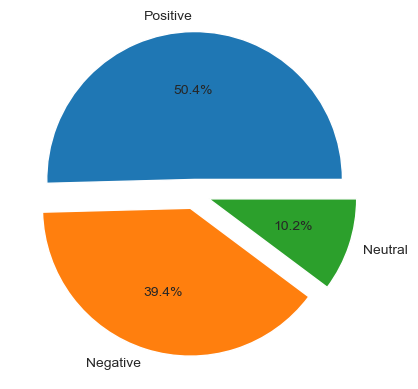

In [19]:
counts=df2['sentiment'].value_counts().to_numpy()
labels =["Positive", "Negative", "Neutral"]
exp = [0.1, 0.1, 0.1]
plt.pie(counts, labels =labels, autopct="%1.1f%%", explode=exp)

## Word Clouds

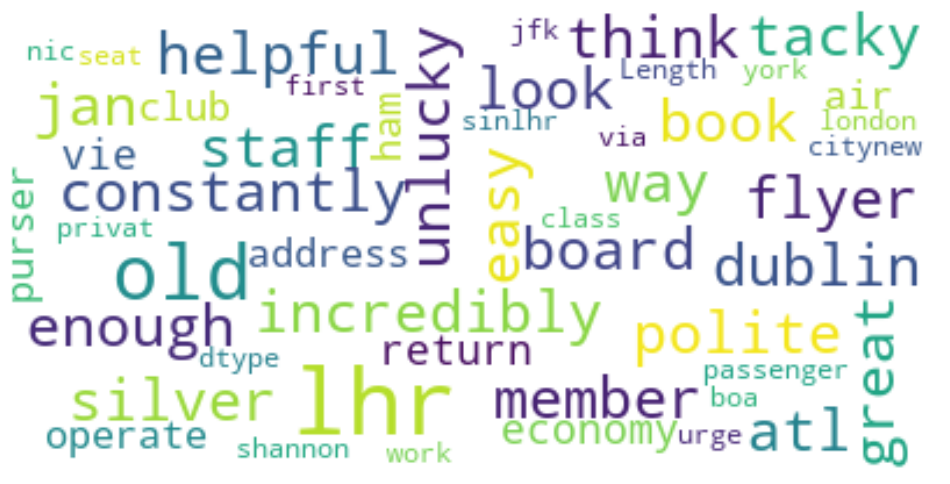

In [20]:
stop=stopwords.words('english')
stop.extend(["british","ba", "airways", "fly", "flight", "aircraft", "name","would", "make", "sp",
            "son","g", "year", "lemme", "find", "airw", "section", "bmi", "really","check","bkk","thing",
            "still"])
wc=WordCloud(background_color='white', stopwords=stop, max_words=50, max_font_size=40, random_state=0).generate(str(df2["lemme"]))

fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

We see a lot of things mentioned in people's reviews. As per the word cloud, lhr is mentioned which is the code for the London - Heathrow airport. Majority of people fly out from lhr through british airways which shows its popularity. We see positive words like easy, helpful, incredibly and polite which could be a description of the British Airways staff or crew. But there are negative words as well such as unlucky, tacky, and old. This shows that some passengers had bad experiences.

In [21]:
pos=df2[df2["sentiment"]=="Positive"]
neg=df2[df2["sentiment"]=="Negative"]

### Positive Word Cloud
We get a closer look of the words mentioned in the positive reviews more clearly here. Looks like passengers were impressed with the BA club as it has many mentions along with helpful and incredibly.

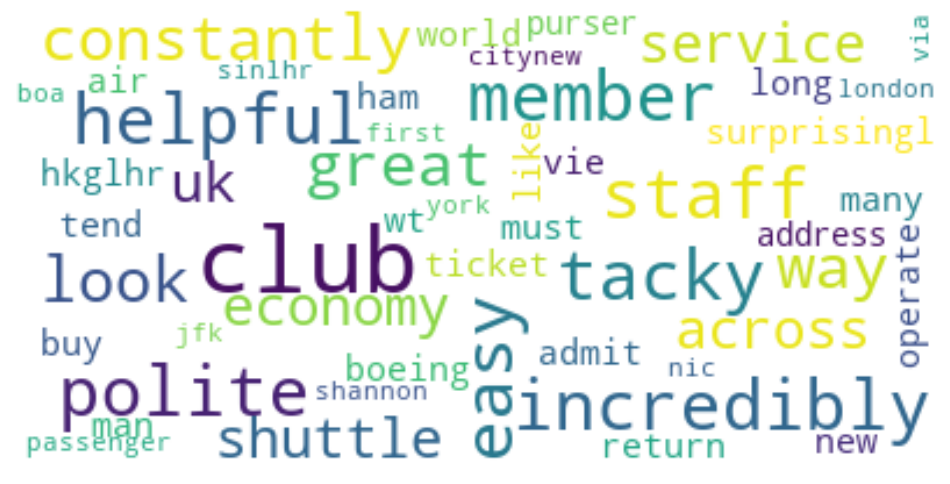

In [24]:
stop.extend(["avoid","lhr"])
wc=WordCloud(background_color='white', stopwords=stop, max_words=50, max_font_size=40, random_state=0).generate(str(pos["lemme"]))

fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative Word Cloud
Some Passengers did not have a good experience and have mentioned in their negative reviews about the economy and business class. This also included words on BA's website and airports. We see words like bad, enough, weird and unlucky. We get an idea of what can be improved in the services of BA to ensure customer satisfaction.

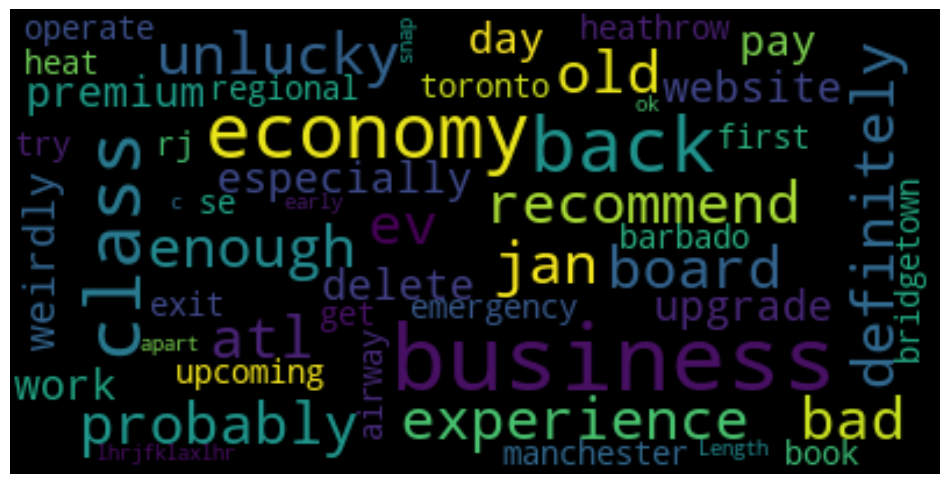

In [25]:
wc=WordCloud(background_color='black', stopwords=stop, max_words=50, max_font_size=40, random_state=0).generate(str(neg["lemme"]))

fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#df2.to_csv("Reviews_upd.csv") To save the dataset

# Modelling

In [26]:
df3=df2[["lemme", "sentiment"]]
df3=df3[df3["sentiment"]!="Neutral"]
x=df3["lemme"]
y=df3["sentiment"]
df3.head()

,lemme,sentiment
0,easy check staff member polite helpful make sp...,Positive
2,find ba incredibly tacky constantly look way g...,Positive
3,fly atl lhr jan unlucky enough board year old ...,Negative
4,great thing british airways economy section up...,Positive
6,probably bad business class experience I ve ev...,Negative


In [27]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.6, random_state=42)

In [28]:
count_vec=CountVectorizer()
count_vec.fit(x_train)
x_tr=count_vec.transform(x_train).toarray()
x_tt=count_vec.transform(x_test).toarray()

In [ ]:
# examine the fitted vocabulary
#count_vec.get_feature_names()

### Naive Baye's Multinomial Model

In [29]:
model=MultinomialNB()
model.fit(x_tr,y_train)

MultinomialNB()

In [30]:
model.score(x_tt,y_test)

0.7995169082125604

In [31]:
ypred=model.predict(x_tt)
metrics.accuracy_score(y_test, ypred)

0.7995169082125604

In [32]:
model.predict(count_vec.transform(["stupid"]).toarray())

array(['Positive'], dtype='<U8')

In [33]:
y_test.value_counts()

Positive    680
Negative    562
Name: sentiment, dtype: int64

We can see that the results are more skewed towards positive as they are in majority

[Text(0.5, 25.52222222222222, 'Predicted'),
 Text(52.722222222222214, 0.5, 'Actual')]

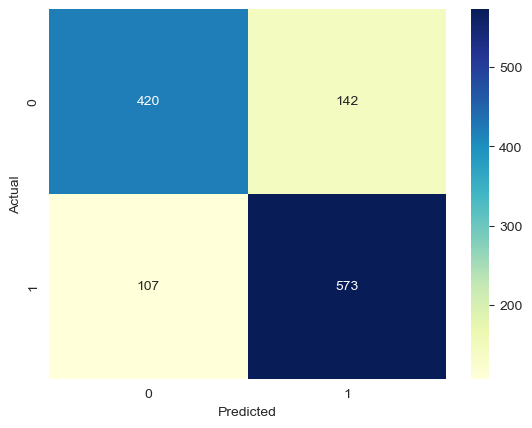

In [34]:
ax = sns.heatmap(metrics.confusion_matrix(y_test, ypred), annot=True, cmap="YlGnBu", fmt="g")
ax.set(xlabel="Predicted", ylabel="Actual")

In [35]:
# These are the messages which are negative but the model is predicting as positive
x_test[ypred > y_test]

2903    miami heathrow january old old style interior ...
232     first time fly ba business class aircraft hope...
2633    uncomfortable serviceless low class low expect...
2327    british airways upmarket world class brand fac...
2953    wednesday december dreamliner lhr calgary club...
                              ...                        
309     travel back mexico city business trip fully aw...
3359    glasgow lhr completely full flight crew amazin...
178     main complaint limit food serve bland barely e...
2158    wife fly british airways london heathrow athen...
1472    fly british airways london heathrow moscow ret...
Name: lemme, Length: 142, dtype: object

In [36]:
# These are the messages which are positive but the model is predicting as negative
x_test[ypred < y_test] #False Negatives

827     london vienna shock ba provide buy onboard sho...
1551    malta gatwick friend arrive check desk long qu...
807     amsterdam london arrive minute late three dela...
1646    late british airways trip london heathrow dall...
466     london cape town book business class ticket ye...
                              ...                        
1589    los angeles london heathrow start charge check...
545     london gatwick san jose costa rica similar exp...
138     ba say ticket flexible cancellation free withi...
1143    husband book honeymoon italy american airlines...
1731    first leg dus lhr club europe business class d...
Name: lemme, Length: 107, dtype: object

In [37]:
y_pred_prob = model.predict_proba(x_tt)[:, 1]

metrics.roc_auc_score(y_test, y_pred_prob)

0.8693897843835043

The Area Under the Curve (AUC) score shows how good the classifer is by checking both sensitivity and specificity. With a score of almost 87% shows that this is a good classifier. But we can try other classifier as well to see their performance.

### Logistic Regression

In [38]:
logmodel=LogisticRegression()
logmodel.fit(x_tr,y_train)

LogisticRegression()

In [39]:
ypred=logmodel.predict(x_tt)
metrics.accuracy_score(y_test, ypred)

0.8397745571658615

[Text(0.5, 25.52222222222222, 'Predicted'),
 Text(52.722222222222214, 0.5, 'Actual')]

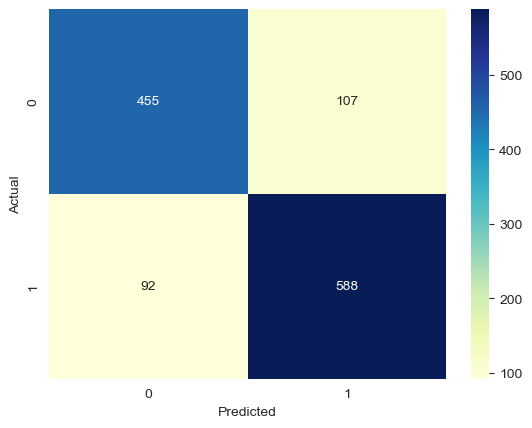

In [40]:
ax = sns.heatmap(metrics.confusion_matrix(y_test, ypred), annot=True, cmap="YlGnBu", fmt="g")
ax.set(xlabel="Predicted", ylabel="Actual")

In [41]:
y_logpred_prob = logmodel.predict_proba(x_tt)[:, 1]

metrics.roc_auc_score(y_test, y_logpred_prob)

0.9156086455934687

Logistic Regression seems to have a higher accuracy of 85% and its AUC score is also 91% which mean it is better at classifying than Naive Bayes. The confusion matrix heatmap also shows that it has less false postive and false negative cases than Naive Bayes.

Naive Bayes assumes that all the data are independent and here as we are trying to classifying the text into positive and negative sentiment, the words dependancy do matter. This could be a reason why naive bayes has a poor performance. While Logistic Regression can model complex relationships between features

Lets try a test message to check sentiment

In [49]:
#A test message
logmodel.predict(count_vec.transform(["What a nice thing to do", "I hate the service"]).toarray())

array(['Positive', 'Negative'], dtype=object)

Will try Cross Validation to check the accuracy of models other than Naive Bayes and Logistic Regression as well.

In [43]:
knn =  KNeighborsClassifier()
rfc = RandomForestClassifier()
dtc =  DecisionTreeClassifier()
clf = [model,logmodel,knn,rfc,dtc]
for algo in clf:
    score = cross_val_score( algo,x_tr,y_train,cv = 10,scoring = 'accuracy')
    print("The accuracy score of {} is:".format(algo),score.mean())

The accuracy score of MultinomialNB() is: 0.8136248634351102
The accuracy score of LogisticRegression() is: 0.8421137369903973
The accuracy score of KNeighborsClassifier() is: 0.6922287390029326
The accuracy score of RandomForestClassifier() is: 0.8120177103099303
The accuracy score of DecisionTreeClassifier() is: 0.72662009085159


By modelling the different classifier it can be seen that still Logistic Regression out performs all of them in terms of accuracy with value of ~85%. Maybe by tuning the hyper-parameters of the different models the accuracy will change. After logistic regression, Naive Bayes' Multinomial model and Random Forest Classifiers were able to achieve around 81%. So if we use a ensemble method to combine the predictions of each different model, there is a chance of improvement to the final accuracy.

### Ensemble Stacking
By using ensemble stacking, the algorithm takes the outputs of sub-models as input and attempts to learn how to best combine the input predictions to make a better output prediction.

In [50]:
vec=CountVectorizer()
vec.fit(x)
x_tr=vec.transform(x)

clf = [('dtc',dtc),('rfc',rfc),('model',model),('knn',knn)]
stack_model = StackingClassifier( estimators = clf,final_estimator = logmodel)
score = cross_val_score(stack_model,x_tr,y,cv = 5,scoring = 'accuracy')
print("The accuracy score is:",score.mean())

The accuracy score is: 0.8179756895745676


After trying the Stacking ensemble method, not much improvement is seen in the accuracy. So on its own Logistic Regression performs well. By tuning the hyperparameters and trying to increase the dataset size, there should be improvement in accuracy.

## Conclusion

After classifying the sentiment of the data using the NLTK VADER model, the text was visualized for insights through word clouds. From that it was deduced that 50.4% were positive reviews in which customers had mentioned easy, polite and helpful for the staff and crew of British Airways. They have described the airlines using words like Great and Incredible. In the 39.4% of Negative reviews, customers have complained on the economy, premium and business classes, and the airlines website. They have mentioned words like bad, old and unlucky which shows that there are few services which could be improved to ensure customer satisfaction.

To be able to identify if a review is positive or negative, a Logistic Regression model was developed having an accuracy of ~85% but ROC as nearly 0.92 showing its effectiveness in classifying the sentiments. With further improvements to the model like tuning the hyperparameters and having more data, would definitely boost the accuracy of the model. This was an attempt to predict sentiment using simple models but with the use of BERT and other LLMs we can scale the effectiveness of this project.